# Frozen Dessert Production Predictions

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

## Preparing Tools and Loading Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [0]:
df = pd.read_csv('/content/drive/My Drive/tensorflow/Data/TF_2_Notebooks_and_Data/DATA/Frozen_Dessert_Production.csv',
                 parse_dates=True,
                 index_col='DATE')

In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [16]:
df.tail()

,production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [0]:
df.columns = ['production']

In [12]:
df.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


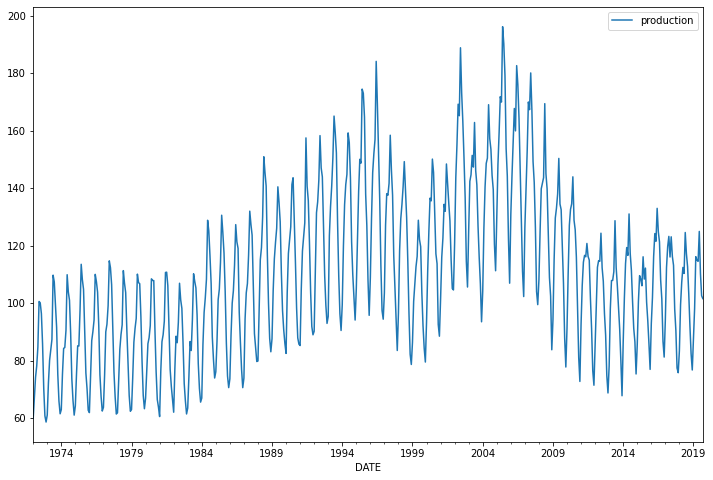

In [14]:
df.plot(figsize=(12,8));

## Train Test Split

In [15]:
len(df)

573

In [17]:
len(df) - 24

549

In [0]:
train_index = len(df) - 24

In [0]:
train = df.iloc[:train_index]
test = df.iloc[train_index:]

In [21]:
train

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2017-05-01,116.0635
2017-06-01,123.0870
2017-07-01,116.2639


In [23]:
test[:10]

,production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118
2018-01-01,83.4343
2018-02-01,99.4899
2018-03-01,107.3152
2018-04-01,112.4309
2018-05-01,110.3544
2018-06-01,124.5841


In [20]:
len(train), len(test)

(549, 24)

## Normalizing

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [27]:
scaled_train[:10]

array([[0.00947104],
       [0.06108982],
       [0.11326273],
       [0.14145625],
       [0.18982663],
       [0.30495972],
       [0.30154406],
       [0.27416065],
       [0.19736841],
       [0.08532665]])

In [28]:
scaled_test[:10]

array([[0.23134679],
       [0.13655347],
       [0.12472921],
       [0.18015997],
       [0.29691617],
       [0.35382169],
       [0.39102302],
       [0.37592272],
       [0.47940099],
       [0.42586022]])

## Time Series Generator


In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12 # 12 months - 1 year
batch_size = 1

generator = TimeseriesGenerator(scaled_train,
                                 scaled_train,
                                 length=length,
                                 batch_size=batch_size)

In [0]:
X, y = generator[0]

In [80]:
X, len(X[0])

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]), 12)

In [81]:
y

array([[0.01774221]])

## Modelling

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

n_features = 1

model = Sequential()

model.add(LSTM(100, activation='relu',
          input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',
              loss='mse')

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test,
                                           length=length,
                                           batch_size=batch_size)

### Callback

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2)

In [86]:
model.fit(generator,
          epochs=20,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0227 - val_loss: 0.0036
Epoch 2/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0212 - val_loss: 0.0031
Epoch 3/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 4/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 5/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 6/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 7/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 8/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 9/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 10/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0032 - val_loss: 0.0022

In [88]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.022689,0.003576
1,0.021166,0.003055
2,0.006330,0.002284
3,0.004743,0.002210
4,0.004320,0.001806
5,0.004038,0.002240
6,0.004030,0.001741
7,0.004190,0.001671
8,0.003635,0.001524
9,0.003246,0.002175


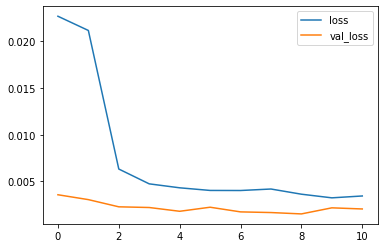

In [89]:
losses.plot()

## Evaluation


In [0]:
test_predictions = []

# grabbing last 12 months from training set to predict 1 month in future
first_eval_batch = scaled_train[-length:]

# reshaping into correct format that is required by the RNN
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [0]:
true_preds = scaler.inverse_transform(test_predictions)

In [92]:
len(true_preds)

24

In [93]:
test['Predictions'] = true_preds
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,production,Predictions
DATE,,
2017-10-01,90.4732,89.346248
2017-11-01,77.4378,82.230442
2017-12-01,75.8118,81.741980
2018-01-01,83.4343,89.571409
2018-02-01,99.4899,100.160566
2018-03-01,107.3152,109.244281
2018-04-01,112.4309,115.376582
2018-05-01,110.3544,118.814619
2018-06-01,124.5841,119.272392


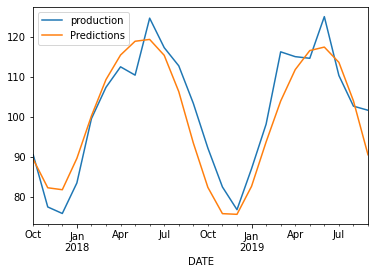

In [94]:
test.plot();

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f'Mean Squared Error: {mean_squared_error(test.production, test.Predictions)}')
print(f'Mean Absolute Error: {mean_absolute_error(test.production, test.Predictions)}')
print(f'Root Mean Squared Error: {mean_squared_error(test.production, test.Predictions)**0.5}')

Mean Squared Error: 37.20597797985186
Mean Absolute Error: 5.11702260191239
Root Mean Squared Error: 6.099670317308294


# Forecasting Values in Future

### Normalizing Full Data

In [95]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)
scaled_full_data[:10]

array([[0.00947104],
       [0.06108982],
       [0.11326273],
       [0.14145625],
       [0.18982663],
       [0.30495972],
       [0.30154406],
       [0.27416065],
       [0.19736841],
       [0.08532665]])

### TimeSeriesGenerator

In [0]:
length=12

genearator = TimeseriesGenerator(scaled_full_data,
                                 scaled_full_data,
                                 length=length,
                                 batch_size=batch_size
                                 )

### Modelling

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

n_features = 1

model = Sequential()

model.add(LSTM(100, activation='relu',
          input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',
              loss='mse')

In [99]:
model.fit_generator(generator,
                    epochs=7)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/7
537/537 [==============================] - 3s 5ms/step - loss: 0.0185
Epoch 2/7
537/537 [==============================] - 3s 5ms/step - loss: 0.0070
Epoch 3/7
537/537 [==============================] - 3s 5ms/step - loss: 0.0060
Epoch 4/7
537/537 [==============================] - 3s 5ms/step - loss: 0.0054
Epoch 5/7
537/537 [==============================] - 3s 5ms/step - loss: 0.0048
Epoch 6/7
537/537 [==============================] - 3s 5ms/step - loss: 0.0048
Epoch 7/7
537/537 [==============================] - 3s 5ms/step - loss: 0.0040


In [100]:
losses = pd.DataFrame(model.history.history)
losses

,loss
0,0.018523
1,0.007012
2,0.005996
3,0.005392
4,0.004834
5,0.004766
6,0.004020


### Evaluating

In [0]:
forecast = []

periods = 12

# grabbing last 12 months from training set to predict 1 month in future
first_eval_batch = scaled_full_data[-length:]

# reshaping into correct format that is required by the RNN
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [102]:
forecast

[array([0.18938023], dtype=float32),
 array([0.13551328], dtype=float32),
 array([0.11809079], dtype=float32),
 array([0.15655385], dtype=float32),
 array([0.22793365], dtype=float32),
 array([0.29480684], dtype=float32),
 array([0.3336664], dtype=float32),
 array([0.3674728], dtype=float32),
 array([0.37984443], dtype=float32),
 array([0.3418206], dtype=float32),
 array([0.3022689], dtype=float32),
 array([0.24535911], dtype=float32)]

In [103]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 84.70221381],
       [ 77.29475907],
       [ 74.89892454],
       [ 80.18813042],
       [ 90.0038445 ],
       [ 99.19983804],
       [104.54356989],
       [109.19241755],
       [110.89368856],
       [105.66488348],
       [100.22597426],
       [ 92.40008782]])

In [104]:
test

,production,Predictions
DATE,,
2017-10-01,90.4732,89.346248
2017-11-01,77.4378,82.230442
2017-12-01,75.8118,81.741980
2018-01-01,83.4343,89.571409
2018-02-01,99.4899,100.160566
2018-03-01,107.3152,109.244281
2018-04-01,112.4309,115.376582
2018-05-01,110.3544,118.814619
2018-06-01,124.5841,119.272392


In [105]:
forecast_index = pd.date_range(start='2019-09-01',
                               periods=periods,
                               freq='MS')

forecast_index

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast, 
                           index=forecast_index,
                           columns=['forecast'])

In [107]:
forecast_df

,forecast
2019-09-01,84.702214
2019-10-01,77.294759
2019-11-01,74.898925
2019-12-01,80.188130
2020-01-01,90.003844
2020-02-01,99.199838
2020-03-01,104.543570
2020-04-01,109.192418
2020-05-01,110.893689
2020-06-01,105.664883


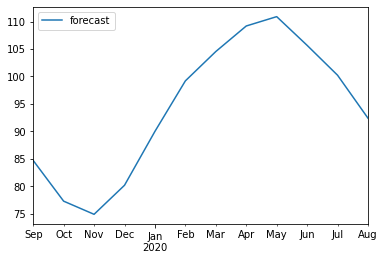

In [108]:
forecast_df.plot()

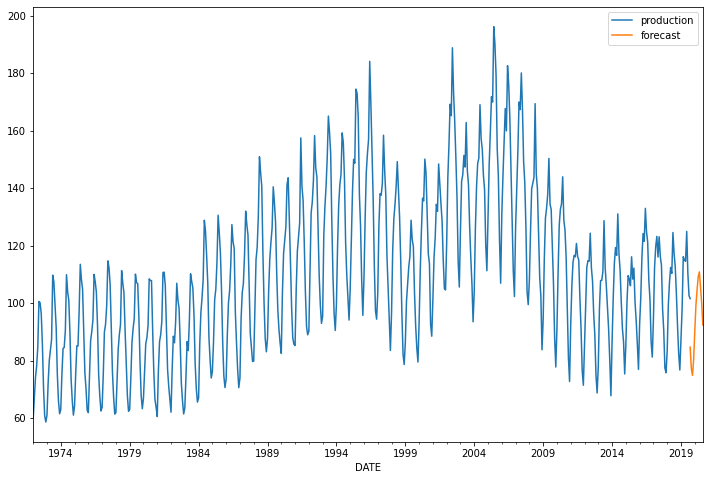

In [109]:
ax = df.plot()
forecast_df.plot(ax=ax,
                 figsize=(12,8));

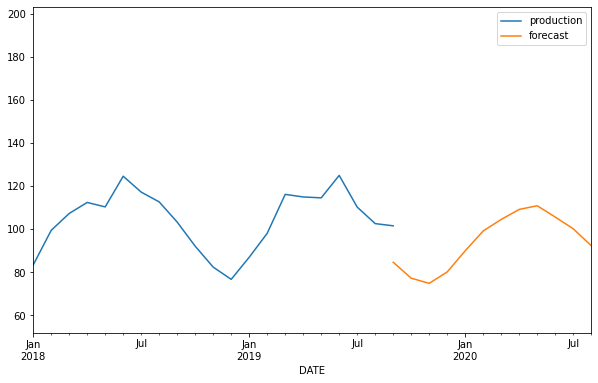

In [110]:
ax = df.plot()
forecast_df.plot(ax=ax,
                 figsize=(10,6));
plt.xlim('2018-01-01', '2020-08-01');